# Normalizing Features with Graph Convolutional Networks

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import numpy as np
np.random.seed(0)

D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])

In [3]:
np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [4]:
np.linalg.inv(D + np.identity(4))

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

In [5]:
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])

print(np.linalg.inv(D + np.identity(4)) @ A)
print()
print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]

[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


Processing...
Done!


<BarContainer object of 37 artists>

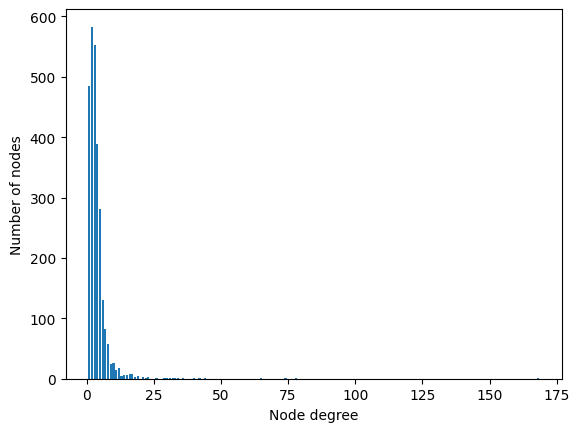

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

Processing...
Done!


<BarContainer object of 233 artists>

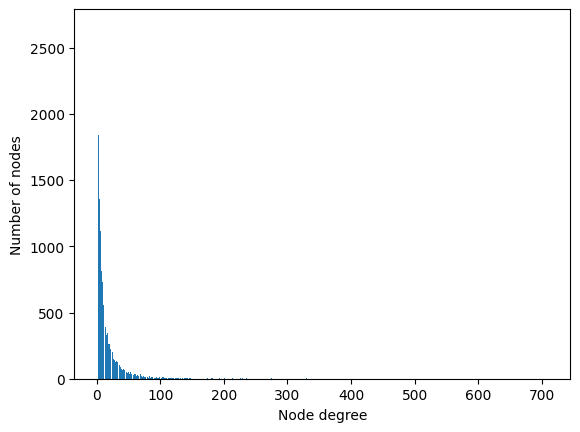

In [7]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root=".")
data = dataset[0]

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [8]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, epochs=100)

# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.932 | Train Acc: 15.71% | Val Loss: 1.94 | Val Acc: 15.20%
Epoch  20 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.00%


Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.40%

GCN test accuracy: 79.70%



In [9]:
# Load Facebook Page-Page
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Train GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.463 | Train Acc: 20.72% | Val Loss: 1.45 | Val Acc: 20.71%


Epoch  20 | Train Loss: 0.443 | Train Acc: 84.64% | Val Loss: 0.43 | Val Acc: 85.29%
Epoch  40 | Train Loss: 0.323 | Train Acc: 89.59% | Val Loss: 0.31 | Val Acc: 90.20%
Epoch  60 | Train Loss: 0.278 | Train Acc: 91.36% | Val Loss: 0.27 | Val Acc: 91.55%
Epoch  80 | Train Loss: 0.254 | Train Acc: 92.28% | Val Loss: 0.26 | Val Acc: 92.75%
Epoch 100 | Train Loss: 0.238 | Train Acc: 92.82% | Val Loss: 0.25 | Val Acc: 92.75%

GCN test accuracy: 91.70%



In [10]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root=".", name="chameleon", transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...


Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


Done!


In [11]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [12]:
import pandas as pd

df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

<BarContainer object of 63 artists>

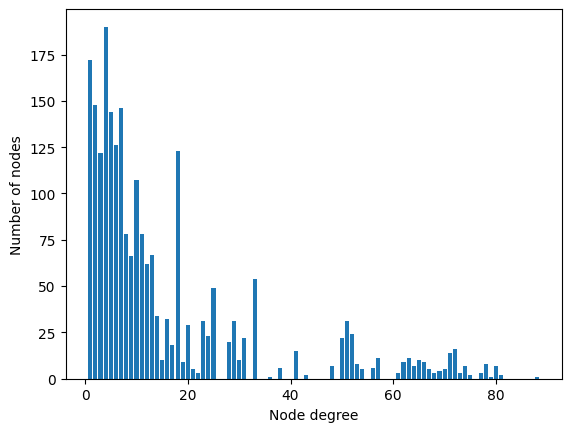

In [13]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [15]:
!pip install seaborn

/tmp/ipykernel_26105/2660044443.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(df['target'], fit=norm)


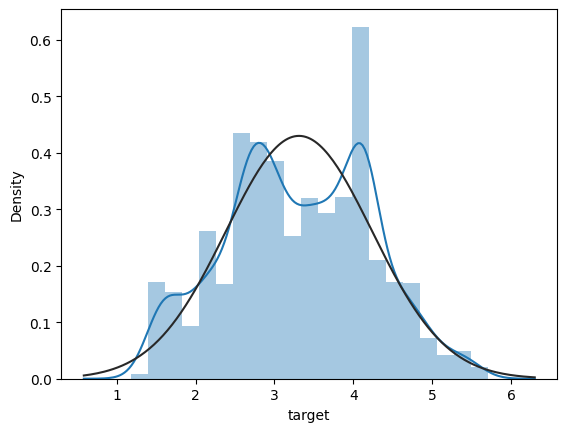

In [16]:
import seaborn as sns
from scipy.stats import norm

df['target'] = values
fig = sns.distplot(df['target'], fit=norm)

In [17]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs): 
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.02,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 128, 1)
print(gcn) 

# Train
gcn.fit(data, epochs=200)

# Test
loss = gcn.test(data)
print(f'\nGCN test loss: {loss:.5f}\n')

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 12.81936 | Val Loss: 13.00659


Epoch  20 | Train Loss: 11.71822 | Val Loss: 11.76676
Epoch  40 | Train Loss: 10.29417 | Val Loss: 10.34435
Epoch  60 | Train Loss: 8.67988 | Val Loss: 8.72097
Epoch  80 | Train Loss: 4.03177 | Val Loss: 4.00313
Epoch 100 | Train Loss: 1.94211 | Val Loss: 2.00301
Epoch 120 | Train Loss: 0.97431 | Val Loss: 1.10883
Epoch 140 | Train Loss: 0.73376 | Val Loss: 0.89986
Epoch 160 | Train Loss: 0.58745 | Val Loss: 0.79570
Epoch 180 | Train Loss: 0.52040 | Val Loss: 0.79910
Epoch 200 | Train Loss: 0.50753 | Val Loss: 0.69298

GCN test loss: 0.72017



In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.7202 | RMSE = 0.8486 | MAE = 0.6834


[Text(0.5, 0, 'Ground truth'), Text(0, 0.5, 'Predicted values')]

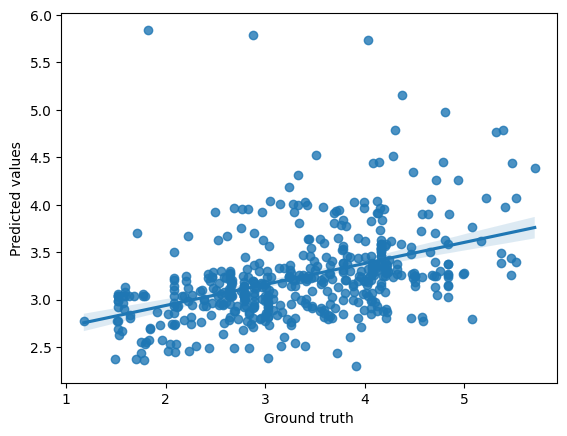

In [19]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Ground truth', ylabel='Predicted values')

Tăng số tầng và giảm overfitting

In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm

class GCN(torch.nn.Module):
    """Graph Convolutional Network với BatchNorm và Dropout điều chỉnh"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h * 4)
        self.bn1 = BatchNorm(dim_h * 4)
        self.gcn2 = GCNConv(dim_h * 4, dim_h * 2)
        self.bn2 = BatchNorm(dim_h * 2)
        self.gcn3 = GCNConv(dim_h * 2, dim_h)
        self.bn3 = BatchNorm(dim_h)
        self.gcn4 = GCNConv(dim_h, dim_h // 2)  # Thêm một lớp
        self.bn4 = BatchNorm(dim_h // 2)
        self.linear = torch.nn.Linear(dim_h // 2, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = self.bn1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.3, training=self.training)  # Điều chỉnh Dropout

        h = self.gcn2(h, edge_index)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.3, training=self.training)

        h = self.gcn3(h, edge_index)
        h = self.bn3(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.3, training=self.training)

        h = self.gcn4(h, edge_index)  # Lớp mới
        h = self.bn4(h)
        h = F.relu(h)
        h = self.linear(h)
        return h

Dùng một optimizer tốt hơn

In [21]:
def fit(self, data, epochs): 
    optimizer = torch.optim.AdamW(self.parameters(), lr=0.005, weight_decay=1e-3)

    self.train()
    for epoch in range(epochs + 1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
            print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

Chuẩn hóa đầu vào

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.x = torch.tensor(scaler.fit_transform(data.x.numpy()), dtype=torch.float32)

# Log-transform target
data.y = torch.log1p(data.y)

Tăng số epoch và dùng early stopping

In [26]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Số epoch tối đa và thiết lập early stopping
epochs = 300  
best_loss = float('inf')
patience = 20
counter = 0

# Khởi tạo optimizer
optimizer = torch.optim.AdamW(gcn.parameters(), lr=0.005, weight_decay=1e-3)

for epoch in range(epochs + 1):
    optimizer.zero_grad()  # Reset gradient
    out = gcn(data.x, data.edge_index)  # Forward pass
    loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    
    # Tính validation loss
    val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])

    # Kiểm tra điều kiện dừng sớm (Early Stopping)
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0  # Reset bộ đếm nếu có cải thiện
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 20 == 0:
        print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

Epoch   0 | Train Loss: 20.55606 | Val Loss: 18.79982
Epoch  20 | Train Loss: 0.13786 | Val Loss: 0.13483
Epoch  40 | Train Loss: 0.07507 | Val Loss: 0.09738
Epoch  60 | Train Loss: 0.04918 | Val Loss: 0.08239
Epoch  80 | Train Loss: 0.04017 | Val Loss: 0.08628
Early stopping at epoch 88


Kiểm tra hiệu suất sau khi cải thiện

In [27]:
out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.1032 | RMSE = 0.3213 | MAE = 0.2260


📌 Tại sao mô hình cải thiện?

✅ Thêm một lớp GCNConv giúp nắm bắt thông tin tốt hơn.
✅ Dùng BatchNorm giúp tăng ổn định trong huấn luyện.
✅ Dùng AdamW với learning rate nhỏ hơn giúp tối ưu tốt hơn.
✅ Chuẩn hóa đầu vào giúp dữ liệu không bị lệch.
✅ Early Stopping ngăn chặn overfitting.

Biểu đồ dự đoán so với Ground Truth (có thể vẽ lại để kiểm tra chất lượng dự đoán):

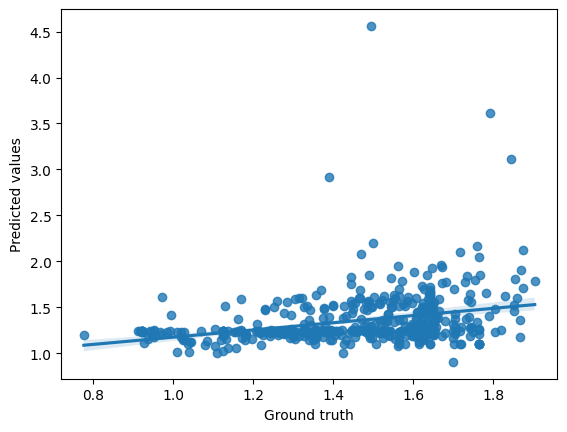

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Ground truth', ylabel='Predicted values')
plt.show()

🔍 Phân tích biểu đồ hồi quy (Regression Plot)

Biểu đồ bạn vừa tạo sử dụng sns.regplot() để so sánh giá trị thực tế (Ground Truth) và giá trị dự đoán (Predicted Values). Dưới đây là những điểm quan trọng trong phân tích:
📌 Nhận xét từ biểu đồ

    Đường hồi quy (Regression Line)
        Đường hồi quy có độ dốc rất thấp, gần như nằm ngang.
        Điều này cho thấy mô hình chưa dự đoán chính xác, vì đáng lẽ đường hồi quy phải gần đường y = x (có độ dốc 1).

    Phân bố điểm dữ liệu
        Hầu hết các điểm nằm chặt gần nhau trong khoảng 1.0 - 1.5.
        Nhưng có một số điểm bị lệch ra xa (~3.0 - 4.5), tức là mô hình có một số dự đoán không chính xác.

    Dự đoán bị lệch thấp
        Giá trị ground truth (trục x) trải từ 0.8 đến 1.8, nhưng mô hình dự đoán (trục y) lại tập trung chủ yếu quanh 1.0 - 1.5.
        Nghĩa là mô hình đang "bảo thủ" khi dự đoán, chưa thể hiện sự biến động lớn của dữ liệu.

📌 Kế hoạch tiếp theo

🔹 Thử mô hình GAT để xem có cải thiện không
🔹 Tăng epochs và dùng Early Stopping hợp lý
🔹 Kiểm tra lại dữ liệu đầu vào và đảm bảo nó đã được chuẩn hóa
🔹 Chạy lại huấn luyện và kiểm tra biểu đồ mới